# 11762 Content-Based Image Retrieval
## Master's Degree in Intelligent Systems
### University of the Balearic Islands

---

In [2]:
# Setup code for this assignment
import cv2
import math
import numpy as np
import os
import scipy.cluster.vq as vq
import tqdm
import zipfile

## Adding parent folder to find other libs
import sys
if ".." not in sys.path:
    sys.path.insert(0,"..")
    
import iric_utils.eval_holidays as ev
import iric_utils.read_descriptors as rd

# Configuring Matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Introduction
In this assignment, you will implement and evaluate different methods for indexing images. As usual during this course, we will use the [INRIA Holidays](http://lear.inrialpes.fr/people/jegou/data.php) dataset. **Check the Assignment 1 to further information about this dataset.**

We also need the provided script to evaluate a CBIR system on this dataset. Remember that the performance is measured computing the **mean average precision** (mAP) over all queries. **Check also the Assignment 1 to remember how to use this script and the different functions it offers.**

### Loading images
As we did in Assignment 1, for managing images, we will create four lists:
- **`query_names`**: File names of the *query* images
- **`query_imgs`**: *Query* images loaded using OpenCV2
- **`train_names`**: File names of the *train* (database) images
- **`train_imgs`**: *Train* images loaded using OpenCV2

In this assignment, we will use the original holidays dataset:

In [134]:
# Separating the dataset into query and train images
query_names = []
query_imgs = []
train_names = []
train_imgs = []

with open('../holidays/holidays_images.dat') as f:
    for line in f:
        imname = line.strip()
        imno = int(imname[:-len(".jpg")])
        img = cv2.imread('../holidays/images/' + imname)
        # Resize the images for a faster operation in this assignment
        img = cv2.resize(img, None, fx=0.25, fy=0.25, interpolation = cv2.INTER_CUBIC)
    
        # Checking if this is a query image
        if imno % 100 == 0:
            query_names.append(imname)
            query_imgs.append(img)
        else:
            train_names.append(imname)
            train_imgs.append(img)

print(len(query_names))
print(len(train_names))

500
991


## Loading SIFT descriptors
In this assignment we will create four additional lists:
- **`query_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *query* images
- **`query_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *query* images
- **`train_kps`**: A list of lists of keypoints (cv2.KeyPoint) extracted from the *train* (database) images
- **`train_desc`**: A list of numpy arrays including, for each set of keypoints, the SIFT descriptors extracted from the *train* images

Unlike in Assigment 1, now you will be provided with a set of SIFT descriptors for each image, and, therefore, you do not need to create these lists from scratch. First, download the descriptors from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_es/Eam8Ld8YDaJAhNr91YVdAZIB_wVZJ8kzzKD7BR6R3LziMw).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

Now, a new directory called `siftgeo` should be in your workspace, containing the set of SIFT descriptors for each image of the dataset. These descriptors are stored in binary format and, thus, you are also provided with some tools to load them. To be more precise, you can call the function `load_SIFT_descriptors` to load the descriptors of a list of images:

In [135]:
# Loading descriptors
query_kps, query_desc = rd.load_SIFT_descriptors(query_names, max_desc=1000)
train_kps, train_desc = rd.load_SIFT_descriptors(train_names, max_desc=1000)

# Some prints
print(len(query_kps))
print(len(train_kps))
print(len(query_desc))
print(len(train_desc))
print(query_desc[0].shape)
print(query_desc[0])

500
991
500
991
(1000, 128)
[[10.  6. 52. ... 15.  4.  0.]
 [16. 50. 12. ... 15.  4.  0.]
 [10. 11. 58. ...  7.  4.  4.]
 ...
 [27. 15.  0. ... 16.  8. 12.]
 [51. 47. 14. ... 35. 26.  0.]
 [ 2. 37. 25. ... 47. 13.  8.]]


In [136]:
img_dict = {}

# Iterate over the training image names and add them to the dictionary
for i, name in enumerate(train_names):
    img_dict[name] = train_imgs[i]
    
# Iterate over the query image names and add them to the dictionary
for i, name in enumerate(query_names):
    img_dict[name] = query_imgs[i]

For development purposes, we use the parameter `max_desc` to load a maximum number (1000) of the descriptors. This will speed up the execution of the rest of the notebook, while the decrease in performance will be minimum.

> **Some images do not have keypoints/descriptors. Take this into account when you develop your solution.**

## $k$-d trees and LSH 
Let's start coding. At this section, you will develop a retrieval system using $k$-d trees and Locality Sensitive Hashing (LSH). 

### General framework
As we did in the first assignment, you first will develop some utilities to simplify your work. Write a function called `search_image` to search an image in a generic index (database). You should search each descriptor of the given query image and obtain its two closest SIFT descriptors in the database. Next, the initial set of matches should be filtered using the **NNDR criterion (use 0.8 as ratio)**, as you did in the previous assignment. For each database image, its final score with regard to this query image will be the **number of correct matches** with this image:

In [49]:
from collections import defaultdict

def search_image(descs, index, id_to_name):
    """
    Search an image in the index
    
    - descs: A numpy array. This is the set descriptors extracted from the query image
    - index: OpenCV FLANN index to search for descriptors.
    - id_to_name: An associative list to link every image index to its real name
        e.g. id_to_name[0] = '100001.jpg', id_to_name[1] = '100002.jpg'
  
    RETURN: 
    - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
    """
  
    # YOUR CODE HERE
    
    # Finding the images that have descriptors, some do not have
    has_descs = np.where(np.any(descs, axis=1))[0]
    if len(has_descs) == 0:
        return []

    # Finding the two nearest neighbors for each query descriptor
    matches = index.knnMatch(queryDescriptors=descs[has_descs], k=2)

    # Filtering the matches using NNDR criterion
    good_matches = defaultdict(int)

    for i, (m, n) in enumerate(matches):
        if m.distance < (0.8 * n.distance):
            img_idx = m.imgIdx
            good_matches[img_idx] += 1

    if not good_matches:
        return []
    
    # Sort images by number of good matches
    sorted_matches = sorted(good_matches.items(), key=lambda x: x[1], reverse=True)

    # Get the names of the images that match the descriptors
    names = []
    for idx, score in sorted_matches:
        name = id_to_name[idx]
        names.append(name)

    return names

Now, write a function called `compute_mAP`. Given a list of query images and a trained index, this function should return a Python dictionary with the ordered results for each query along with the computed mAP:

In [7]:
def compute_mAP(query_names, query_desc, index, id_to_name):
    """
    Perform a search for a list of query images against the database.
    
    - query_names: An ordered list with the names of the query images
    - query_desc: A list containing numpy arrays of size (ndesc_for_this_image, 128)
                  Each numpy array i corresponds to the descriptors found at image i
    - index: FLANN index
    - id_to_name: An associative array to link every image index to its real name
                  e.g. id_to_name[0] = '100001.jpg', id_to_name[1] = '100002.jpg'
  
    RETURN: 
    - total_results: A dictionary containing, for each query image, an sorted list of the database images
    - m_ap: Mean Average Precision averaged over all queries
    """
    total_results = {}
    m_ap = 0.0
  
    # YOUR CODE HERE
    for i, qname in enumerate(query_names):
        qdesc = query_desc[i]
        results = search_image(qdesc, index, id_to_name)
        total_results[qname] = results
        
        # Compute AP for this query
        gt = set([name for name in results if name.startswith(qname[:4])])
        ap = 0.0
        num_correct = 0
        if len(gt) == 0:
            ap = 0.0
        else:
            for j, rname in enumerate(results):
                if rname.startswith(qname[:4]):
                    num_correct += 1
                    ap += float(num_correct) / (j+1)

            ap /= len(gt)
        m_ap += ap
    
    m_ap /= len(query_names)
    
    return total_results, m_ap

### $k$-d Trees
In this section you will use a set of randomized $k$-d trees to index the database of images. Write a function called `build_db_kdtrees` to build a set of randomized $k$-d trees given a set of descriptors:

> **Useful links**: [cv2.FlannBasedMatcher](https://docs.opencv.org/4.5.5/dc/de2/classcv_1_1FlannBasedMatcher.html), [Possible algorithms to create an index](https://docs.opencv.org/4.5.5/db/d18/classcv_1_1flann_1_1GenericIndex.html#a8fff14185f9f3d2f2311b528f65b146c), [Algorithms IDs](https://github.com/opencv/opencv/blob/master/modules/flann/include/opencv2/flann/defines.h#L70)

In [8]:
def build_db_kdtrees(descs, ntrees = 4):
    """
    Build a set of randomized k-d trees.
    
    - descs: A list of length len(img_names) where each element is a numpy array 
        of size (ndesc_for_this_image, 128). Each numpy array i corresponds 
        to the descriptors found on image i
    - ntrees: Number of trees to train
  
    RETURN: 
    - index: Trained FLANN index
    """  
    index = None
  
    # YOUR CODE HERE
    
    # Convert descriptors to float32
    descs = [desc.astype(np.float32) for desc in descs]
  
    # Set up FLANN matcher with KDTreeIndexParams
    index_params = dict(algorithm=1, trees=ntrees)
    flann = cv2.FlannBasedMatcher(index_params, {})
    
    # Add descriptors to FLANN index
    flann.add(descs)
    
    # Train the FLANN index
    flann.train()
    
    # Get the trained FLANN index
    index = flann
    
    return index

In [9]:
# Simple example of DB construction
index = build_db_kdtrees(train_desc[0:2])
print(len(index.getTrainDescriptors()))

2


In [10]:
# Search an image in the index
img_res = search_image(query_desc[0], index, train_names[0:2])
print(img_res)

['100002.jpg', '100001.jpg']


In [11]:
# Example of computing mAP
results, mAP = compute_mAP(query_names, query_desc, index, train_names[0:2])
print(results['100000.jpg'])
print(results['100100.jpg'])
print(mAP) # This should be 0 now, since there is only two images in the database.

['100002.jpg', '100001.jpg']
['100001.jpg', '100002.jpg']
0.002


**Q1**: Using functions developed so far, in the following cell compute the resulting **mAP** of the system **using 4 trees**:

In [12]:
# Fill this variable with the resulting mAP
mAP_kdtree = 0.0

# YOUR CODE HERE

index = build_db_kdtrees(train_desc,4) #using kd-tree with 4 trees

# Compute mAP
results, mAP_kdtree = compute_mAP(query_names, query_desc, index, train_names)

In [13]:
print('mAP: %.5f' % mAP_kdtree)

mAP: 0.77856


**Q2**: Are the results stable? Do you obtain always the same mAP? Why?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

In [14]:
# To check if the results are stable and if we obtain always the same mAP
# we can run the code multiple times and compare the results.

num_experiments = 10

mAPs = []
for i in range(num_experiments):
    index = build_db_kdtrees(train_desc,4)
    results, mAP_kdtree = compute_mAP(query_names, query_desc, index, train_names)
    mAPs.append(mAP_kdtree)
    print(f"Experiment {i+1}: mAP using kd-tree with 4 trees:", mAP_kdtree)

print("Average mAP:", np.mean(mAPs))

Experiment 1: mAP using kd-tree with 4 trees: 0.7702714483561388
Experiment 2: mAP using kd-tree with 4 trees: 0.7764661630623666
Experiment 3: mAP using kd-tree with 4 trees: 0.7720657975581351
Experiment 4: mAP using kd-tree with 4 trees: 0.7844685556823638
Experiment 5: mAP using kd-tree with 4 trees: 0.7781878946984672
Experiment 6: mAP using kd-tree with 4 trees: 0.7744519540251799
Experiment 7: mAP using kd-tree with 4 trees: 0.7832825039563117
Experiment 8: mAP using kd-tree with 4 trees: 0.7761060906137679
Experiment 9: mAP using kd-tree with 4 trees: 0.7713382749672067
Experiment 10: mAP using kd-tree with 4 trees: 0.7760587150850844
Average mAP: 0.7762697398005022


The mAP values obtained in each experiment are different. This is because kd-tree is a randomized algorithm that depends on the initial random state and the data distribution. As a result, different runs of the same algorithm on the same data can result in slightly different outcomes.

**Q3:** Analyze the effect of changing the number of trees in terms of mAP and average response time. Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

In [15]:
import time

# Defining the number of trees to evaluate
num_trees = [1, 2, 4, 8, 16, 32]

mAPs = []
times = []
for t in num_trees:
    index = build_db_kdtrees(train_desc, t)
    start_time = time.time()
    results, mAP_kdtree = compute_mAP(query_names, query_desc, index, train_names)
    end_time = time.time()
    elapsed_time = end_time - start_time
    mAPs.append(mAP_kdtree)
    times.append(elapsed_time)
    print(f"mAP using kd-tree with {t} trees:", mAP_kdtree)
    print(f"Average response time using kd-tree with {t} trees: {elapsed_time/len(query_names):.4f} seconds per query.")


mAP using kd-tree with 1 trees: 0.7707092502680138
Average response time using kd-tree with 1 trees: 0.0178 seconds per query.
mAP using kd-tree with 2 trees: 0.7755359529926559
Average response time using kd-tree with 2 trees: 0.0228 seconds per query.
mAP using kd-tree with 4 trees: 0.7793499843626158
Average response time using kd-tree with 4 trees: 0.0272 seconds per query.
mAP using kd-tree with 8 trees: 0.7777872661794019
Average response time using kd-tree with 8 trees: 0.0293 seconds per query.
mAP using kd-tree with 16 trees: 0.7881833293993585
Average response time using kd-tree with 16 trees: 0.0413 seconds per query.
mAP using kd-tree with 32 trees: 0.7898629251304252
Average response time using kd-tree with 32 trees: 0.0524 seconds per query.


The results show that as the number of trees increases, the mAP score also increases, which indicates that using more trees in the kd-tree can improve the retrieval performance. However, this comes at a cost of increased average response time per query, as more trees need to be traversed to find the nearest neighbors. Therefore, there is a trade-off between retrieval performance and speed.

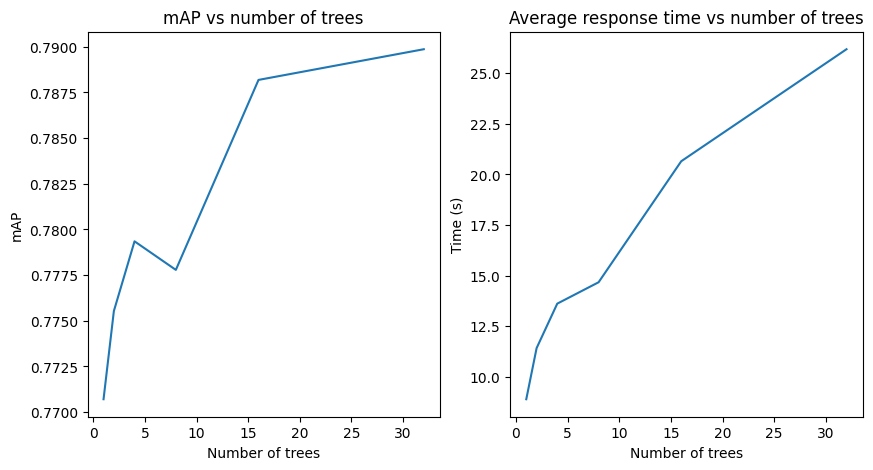

In [16]:
# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(num_trees, mAPs)
plt.title('mAP vs number of trees')
plt.xlabel('Number of trees')
plt.ylabel('mAP')

plt.subplot(1, 2, 2)
plt.plot(num_trees, times)
plt.title('Average response time vs number of trees')
plt.xlabel('Number of trees')
plt.ylabel('Time (s)')
plt.show()

### Locality Sensitive Hashing (LSH)
In this section, you will use LSH to index the database of images. The LSH implementation included in OpenCV uses **bit sampling** for **Hamming distance** as a hash function and, therefore, binary descriptors must be used. Hence, SIFT descriptors are not valid and we need to describe the images, but using, for instance, ORB.

In the following cell, write the code required to generate **roughly 1500 keypoints / descriptors** using ORB for each query / train image:

> **Useful links**: [cv2.ORB_create](https://docs.opencv.org/4.5.4/db/d95/classcv_1_1ORB.html#aeff0cbe668659b7ca14bb85ff1c4073b)

In [17]:
query_kps_orb  = []
query_desc_orb = []
train_kps_orb  = []
train_desc_orb = []

# YOUR CODE HERE
orb = cv2.ORB_create(nfeatures=1500)

# Loop over query images
for img in query_imgs:
    # Find keypoints and descriptors
    kps, desc = orb.detectAndCompute(img, None)
    query_kps_orb.append(kps)
    query_desc_orb.append(desc)

# Loop over train images
for img in train_imgs:
    # Find keypoints and descriptors
    kps, desc = orb.detectAndCompute(img, None)
    train_kps_orb.append(kps)
    train_desc_orb.append(desc)

In [25]:
# Show some data
print(len(query_kps_orb[0]))
print(query_desc_orb[0].shape)
print(query_desc_orb[0])

1500
(1500, 32)
[[124  43 176 ... 111 222   3]
 [ 56 141 104 ...  42 212 234]
 [227 182 190 ...  68 207 223]
 ...
 [ 33 201 205 ... 154 218 140]
 [ 76  18 140 ...  67 141  83]
 [199  92 149 ...  89 137  22]]


Next, write a function called `build_db_lsh` to build a **standard** (*no multi-probe*) LSH index from a set of images:

In [50]:
def build_db_lsh(descs, tables = 6, hash_size = 12):
    """
    Index a set of images using LSH.    
    
    - descs: A list containing numpy arrays of size (~1500, 32). Each numpy array
        i corresponds to the ORB descriptors found at image i.
    - tables: Number of hash tables to create.
    - hash_size: Hash length in bits.
  
    RETURN: 
    - index: The trained LSH index.
    """  
    index = None
  
    # YOUR CODE HERE
    
    index_params = dict(algorithm=6, table_number=tables, key_size=hash_size, multi_probe_level=0)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    flann.add(descs)
    
    index = flann
    
    return index

In [31]:
# Simple example of DB construction
index = build_db_lsh(train_desc_orb[0:2])
print(len(index.getTrainDescriptors()))

2


**Q4**: In the following cell compute the resulting **mAP** of the system **using 6 tables and a hash size of 12**:

Since it takes too long time to calculate all the query dataset, the first 50 images are calculated

In [52]:
# Fill this variable with the resulting mAP
mAP_lsh = 0.0

# YOUR CODE HERE
index = build_db_lsh(train_desc_orb)

# Compute mAP
results, mAP_lsh = compute_mAP(query_names[0:50], query_desc_orb[0:50], index, train_names)

In [34]:
print('mAP: %.5f' % mAP_lsh)

mAP: 0.62774


**Q5**: Are the results stable? Do you obtain always the same mAP? Why?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

In [35]:
# To check if the results are stable and if we obtain always the same mAP
# we can run the code multiple times and compare the results.

num_experiments = 3

mAPs = []
for i in range(num_experiments):
    index = build_db_lsh(train_desc_orb)
    results, mAP_lsh = compute_mAP(query_names[0:50], query_desc_orb[0:50], index, train_names)
    mAPs.append(mAP_lsh)
    print(f"Experiment {i+1}: mAP using LSH:", mAP_lsh)

print("Average mAP:", np.mean(mAPs))

Experiment 1: mAP using LSH: 0.5886887673729779
Experiment 2: mAP using LSH: 0.6410168498168498
Experiment 3: mAP using LSH: 0.6350350877192983
Average mAP: 0.6215802349697087


The results are not completely stable, as we can see that the mAP values obtained for each experiment are different. However, they are relatively close to each other, with a difference of about 0.05 or less. This suggests that the LSH index is performing consistently across different runs, but there is some random variation in the results due to the probabilistic nature of LSH.

LSH is a randomized algorithm that uses random hash functions to partition the data into multiple hash tables. As a result, the exact outcome of LSH can vary between different runs, even if the input data and parameters are the same. However, the overall performance of LSH is expected to be relatively stable.



**Q6**: Analyze the effect of changing the number of tables / hash size in terms of mAP and average response time. Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

In [53]:
import time

# Defining the number of trees to evaluate
num_tables = [4, 6, 8]
hash_sizes = [10, 12, 16]

mAPs = []
times = []
for t in num_tables:
    mAPs_row = []
    for h in hash_sizes:
        index = build_db_lsh(train_desc_orb,t, h)
        start_time = time.time()
        results, mAP_lsh = compute_mAP(query_names[0:50], query_desc_orb[0:50], index, train_names)
        end_time = time.time()
        elapsed_time = end_time - start_time
        mAPs.append(mAP_lsh)
        times.append(elapsed_time)
        print(f"mAP using LSH with {t} tables and {h} hash size:", mAP_lsh)
        print(f"Average response time using LSH with {t} tables and {h} hash size: {elapsed_time/len(query_names):.4f} seconds per query.")
        mAPs_row.append(mAP_lsh)
    mAPs.append(mAPs_row)


mAP using LSH with 4 tables and 10 hash size: 0.6175992063492064
Average response time using LSH with 4 tables and 10 hash size: 0.1489 seconds per query.
mAP using LSH with 4 tables and 12 hash size: 0.6224528985507246
Average response time using LSH with 4 tables and 12 hash size: 0.0487 seconds per query.
mAP using LSH with 4 tables and 16 hash size: 0.6037477253928867
Average response time using LSH with 4 tables and 16 hash size: 0.0095 seconds per query.
mAP using LSH with 6 tables and 10 hash size: 0.6134494569757729
Average response time using LSH with 6 tables and 10 hash size: 0.2492 seconds per query.
mAP using LSH with 6 tables and 12 hash size: 0.602502563511638
Average response time using LSH with 6 tables and 12 hash size: 0.1095 seconds per query.
mAP using LSH with 6 tables and 16 hash size: 0.5711423923923924
Average response time using LSH with 6 tables and 16 hash size: 0.0145 seconds per query.
mAP using LSH with 8 tables and 10 hash size: 0.6096297313797314
Averag

The results suggest that increasing the number of tables or hash size has a varying effect on both mAP and average response time.

Regarding mAP, it appears that changing the number of tables has a minor impact on the results, while changing the hash size has a more significant impact. In particular, increasing the hash size from 10 to 12 generally leads to an improvement in mAP, while further increasing it to 16 leads to a decrease in mAP in most cases.



On the other hand, changing the number of tables has a more significant impact on average response time, with a higher number of tables leading to longer processing times. This is particularly evident when using a small hash size of 10, where increasing the number of tables from 4 to 8 leads to a significant increase in average response time. However, this effect is less pronounced when using larger hash sizes of 12 and 16.

**Q7:** Despite the different descriptors used, compare the performance of the randomized k-d trees and LSH approaches from different points of view (accuracy, training times, querying times, ...). Some plots can be useful here to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

In [111]:
# Compute mAP using kd-trees
index_kdtree = build_db_kdtrees(train_desc)
results_kdtree, mAP_kdtree = compute_mAP(query_names[:50], query_desc[:50], index_kdtree, train_names)

# Compute mAP using LSH
index_lsh = build_db_lsh(train_desc_orb)
results_lsh, mAP_lsh = compute_mAP(query_names[:50], query_desc_orb[:50], index_lsh, train_names)


In [112]:
# Measure training time for kd-trees
start_time = time.time()
index_kdtree = build_db_kdtrees(train_desc, ntrees=4)
training_time_kdtree = time.time() - start_time

# Measure training time for LSH
start_time = time.time()
index_lsh = build_db_lsh(train_desc_orb, tables=6, hash_size=12)
training_time_lsh = time.time() - start_time


In [119]:
# Measure querying time for kd-trees
start_time = time.time()
results_kdtree, mAP_kdtree = compute_mAP(query_names[:50], query_desc[:50], index_kdtree, train_names)
querying_time_kdtree = time.time() - start_time

# Measure querying time for LSH
start_time = time.time()
results_lsh, mAP_lsh = compute_mAP(query_names[:50], query_desc_orb[:50], index_lsh, train_names)
querying_time_lsh = time.time() - start_time


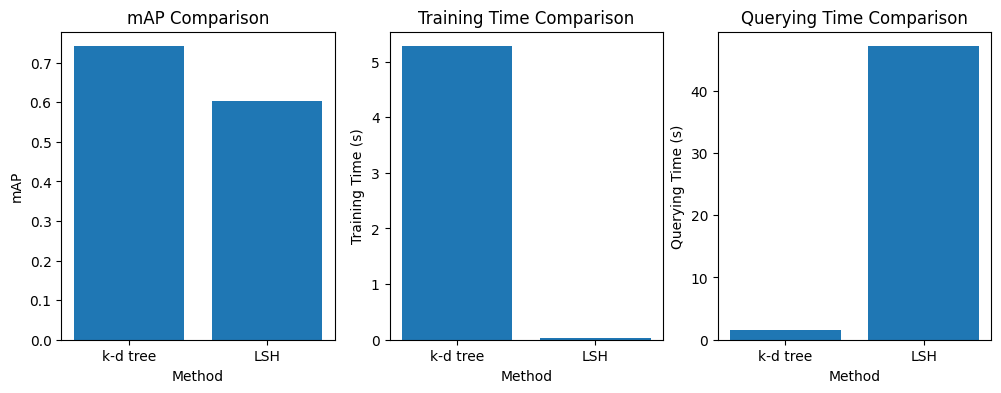

In [126]:
# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot mAP
axs[0].bar(['k-d tree', 'LSH'], [mAP_kdtree, mAP_lsh])
axs[0].set_xlabel('Method')
axs[0].set_ylabel('mAP')
axs[0].set_title('mAP Comparison')

# Plot training time
axs[1].bar(['k-d tree', 'LSH'], [training_time_kdtree, training_time_lsh])
axs[1].set_xlabel('Method')
axs[1].set_ylabel('Training Time (s)')
axs[1].set_title('Training Time Comparison')

# Plot querying time
axs[2].bar(['k-d tree', 'LSH'], [querying_time_kdtree, querying_time_lsh])
axs[2].set_xlabel('Method')
axs[2].set_ylabel('Querying Time (s)')
axs[2].set_title('Querying Time Comparison')

plt.show()


The results show that the k-d tree method performs better than the LSH method in terms of mAP, with a higher score of 0.741 compared to 0.603. Also, the k-d tree method is much faster than the k-d tree method in querying time, with tquerying times of 47.09 and 1.58 seconds, respectively. On the other hand, LSH is faster in training time, with the values 0.027 and 5.27 seconds.

## Bag-of-Words
In this section, you will implement the Bag-of-Words (BoW) model for image retrieval. Additionally, you will also implement the TF-IDF scoring scheme.

### Download visual dictionaries
To use a BoW model, first we need a visual vocabulary. The authors of the INRIA Holidays dataset provide some visual vocabularies, trained using a clustering method (e.g. $k$-means) in a different dataset (Flickr60K).

First, download these vocabularies from [here](https://uibes-my.sharepoint.com/:u:/g/personal/egf350_id_uib_es/EY1G011OvfJOnwqWQQzmHmgBkXhLHBaK00wdizsUT252dw).

> **Unzip this file into the root directory of the development kit, at the same level of the datasets.**

A folder named `clust` is now available in your workspace, containing visual vocabularies of 100, 200, 500, 1K, 2K, 5K, 10K, 20K, 50K, 100K and 200K visual words. Again, these are binary files, and therefore we provide you with functions to load and index them:

In [4]:
voc = rd.load_visual_vocab("../clust/clust_flickr60_k200.fvecs", ntrees=4)

With this function, the corresponding vocabulary is read. Additionally, a FLANN index structure based on kd-trees is built and returned using the centroids. This is to allow a fast access when searching for the closest visual words in the vocabulary. More precisely, in this example, 4 trees are constructed using the vocabulary of 200 centroids. Now, given a query descriptor(s), you can use `match` or `knnMatch` methods as usual to search for the closest (approximate) visual word(s) in the vocabulary.

### BoW and Inverted File
Now, write a class called `BoW` to manage the indexing procedure. This class should make use, in addition to the visual vocabulary, an inverted file to compute similarity scores between images. Apart from the class constructor, write three methods: `build_db`, `search_image` and `compute_mAP`:

In [72]:
from sklearn.metrics import average_precision_score

class BoW:
    """
    Class to implement the BoW model + Inverted File.
    """
  
    def __init__(self, vocab_file):
        """
        Class constructor. It loads the vocabulary and initializes other stuff
        required for the CBIR system, such as the inverted file structure.
        """
        self.vocab = rd.load_visual_vocab(vocab_file)
        self.nwords = self.vocab.getTrainDescriptors()[0].shape[0]
        self.train_names = []
        self.inv_list = {word_id: {} for word_id in range(self.nwords)}

    def build_db(self, img_names, img_descs):
        """
        Build an index from a set of images. Essentially, for each image, you should
        search its descriptors in the index in order to find the closest visual words
        and fill the inverted file structure consequently.
    
        - img_names: An ordered list with the names of the train images
        - img_descs: A list containing numpy arrays. Each numpy array i corresponds 
          to the descriptors found at image i
        """
        # YOUR CODE HERE                  
        for i, img_desc in enumerate(img_descs):
            visual_words = self.vocab.knnMatch(img_desc, k=1)
            bow_hist = np.zeros(self.nwords)

            for vw in visual_words:
                word_id = vw[0].trainIdx
                bow_hist[word_id] += 1
            
            if len(img_desc) != 0:
                bow_hist /= len(img_desc)

            for word_id, word_count in enumerate(bow_hist):
                if word_count > 0:
                    if img_names[i] not in self.inv_list[word_id]:
                        self.inv_list[word_id][img_names[i]] = []
                    self.inv_list[word_id][img_names[i]].append(word_count)

    def search_image(self, descs):
        """
        Search an image in the index.
      
        - descs: A numpy array. It is the set descriptors extracted from the query image.
    
        RETURN:
        - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
        """
        # YOUR CODE HERE
        visual_words = self.vocab.knnMatch(descs, k=1)
        bow_hist = np.zeros(self.nwords)

        for vw in visual_words:
            word_id = vw[0].trainIdx
            bow_hist[word_id] += 1
        
        if len(descs) != 0:
            bow_hist /= len(descs)

        # Compute the scores for each image in the index
        scores = {}
        for word_id, word_count in enumerate(bow_hist):
            if word_count == 0:
                continue
            for image_id, counts in self.inv_list[word_id].items():
                if image_id not in scores:
                    scores[image_id] = 0
                scores[image_id] += word_count * sum(counts) / len(counts)

        sorted_images = sorted(scores, key=scores.get, reverse=True)
        return sorted_images  
     
    def compute_mAP(self, query_names, query_descs, gt_file='../holidays/holidays_images.dat'):
        """
        Perform a search for a list of query images against the database and evaluates
        the performance of the system.
        
        - query_names: An ordered list with the names of query images
        - query_descs: A list containing numpy arrays of size (ndesc_for_this_image, 128). 
              Each numpy array i corresponds to the descriptors found at image i.

        RETURN:
        - total_results: A dictionary containing, for each query image, an ordered list of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        """
        total_results = {}
        m_ap = 0.0

        # YOUR CODE HERE
        for qname, qdesc in zip(query_names, query_descs):
            # Search for similar images
            results = self.search_image(qdesc)
            total_results[qname] = results

        m_ap = ev.compute_mAP(total_results, gt_file)
        
        return total_results, m_ap

In [73]:
# Example of use
index = BoW('../clust/clust_flickr60_k200.fvecs')
index.build_db(train_names[0:2], train_desc[0:2])

In [74]:
res = index.search_image(query_desc[0])
print(res)

['100001.jpg', '100002.jpg']


In [75]:
results, mAP = index.compute_mAP(query_names, query_desc)
print(results)
print(mAP)

{'100000.jpg': ['100001.jpg', '100002.jpg'], '100100.jpg': ['100002.jpg', '100001.jpg'], '100200.jpg': ['100001.jpg', '100002.jpg'], '100300.jpg': ['100001.jpg', '100002.jpg'], '100400.jpg': ['100001.jpg', '100002.jpg'], '100500.jpg': ['100001.jpg', '100002.jpg'], '100600.jpg': ['100002.jpg', '100001.jpg'], '100700.jpg': ['100002.jpg', '100001.jpg'], '100800.jpg': ['100001.jpg', '100002.jpg'], '100900.jpg': ['100002.jpg', '100001.jpg'], '101000.jpg': ['100002.jpg', '100001.jpg'], '101100.jpg': ['100002.jpg', '100001.jpg'], '101200.jpg': ['100002.jpg', '100001.jpg'], '101300.jpg': ['100002.jpg', '100001.jpg'], '101400.jpg': ['100002.jpg', '100001.jpg'], '101500.jpg': ['100002.jpg', '100001.jpg'], '101600.jpg': ['100001.jpg', '100002.jpg'], '101700.jpg': ['100002.jpg', '100001.jpg'], '101800.jpg': ['100002.jpg', '100001.jpg'], '101900.jpg': ['100002.jpg', '100001.jpg'], '102000.jpg': ['100002.jpg', '100001.jpg'], '102100.jpg': ['100002.jpg', '100001.jpg'], '102200.jpg': ['100002.jpg', '1

In [78]:
index.build_db(train_names, train_desc)
results, mAP = index.compute_mAP(query_names, query_desc)
print(mAP)

0.06487850415287062


**Q8**: In the following cell compute the resulting mAP of the system **using the vocabularies of 200, 2K, 20K and 200K visual words**:

In [82]:
# Fill these variables with the resulting mAP
mAP_200  = 0.0
mAP_2K   = 0.0
mAP_20K  = 0.0
mAP_200K = 0.0

import time

# YOUR CODE HERE
start_time = time.time()
index_200 = BoW('../clust/clust_flickr60_k200.fvecs')
index_200.build_db(train_names, train_desc)
train_time_200 = time.time() - start_time
print("train_time_200 %s seconds: ", train_time_200)
results_200, mAP_200 = index_200.compute_mAP(query_names, query_desc)

start_time = time.time()
index_2K = BoW('../clust/clust_flickr60_k2000.fvecs')
index_2K.build_db(train_names, train_desc)
train_time_2K = time.time() - start_time
print("train_time_2K %s seconds: ", train_time_2K)
results_2K, mAP_2K = index_2K.compute_mAP(query_names, query_desc)

start_time = time.time()
index_20K = BoW('../clust/clust_flickr60_k20000.fvecs')
index_20K.build_db(train_names, train_desc)
train_time_20K = time.time() - start_time
print("train_time_20K %s seconds: ", train_time_20K)
results_20K, mAP_20K = index_20K.compute_mAP(query_names, query_desc)

start_time = time.time()
index_200K = BoW('../clust/clust_flickr60_k200000.fvecs')
index_200K.build_db(train_names, train_desc)
train_time_200K = time.time() - start_time
print("train_time_200K %s seconds: ", train_time_200K)
results_200K, mAP_200K = index_200K.compute_mAP(query_names, query_desc)

train_time_200 %s seconds:  8.122374057769775
train_time_2K %s seconds:  8.685343980789185
train_time_20K %s seconds:  15.343914985656738
train_time_200K %s seconds:  37.37079381942749


In [83]:
print('mAP 200: %.5f' % mAP_200)
print('mAP 2K: %.5f' % mAP_2K)
print('mAP 20K: %.5f' % mAP_20K)
print('mAP 200K: %.5f' % mAP_200K)

mAP 200: 0.06577
mAP 2K: 0.13785
mAP 20K: 0.25445
mAP 200K: 0.38384


**Q9**: Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

We can observe that the mAP increases as the size of the vocabulary increases. However, a larger vocabulary size does not always guarantee better performance. Increasing the size of the vocabulary leads to a higher level of granularity in the description of the visual content, which can be useful in distinguishing between similar images. However, too much granularity can also result in overfitting, where the system becomes too specialized to the training dataset and fails to generalize well to unseen data.

Additionally, a larger vocabulary size requires more computational resources, both for building the index and for performing the retrieval. Therefore, there is a trade-off between accuracy and efficiency, and the optimal vocabulary size depends on the specific application and hardware constraints.

**Q10**: Analyze the effect of the vocabulary size in terms of mAP and average response time (train and query times). Are these times constant for each vocabulary? Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

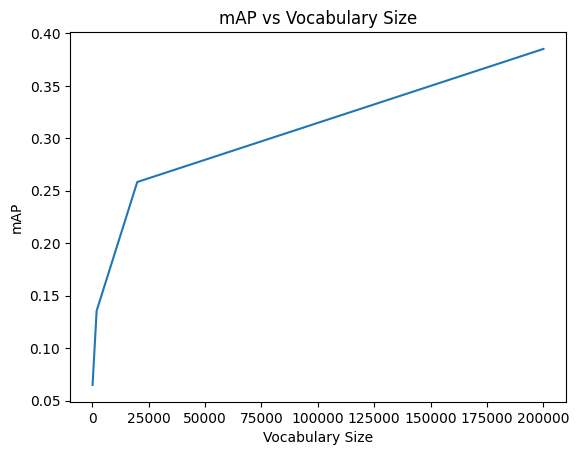

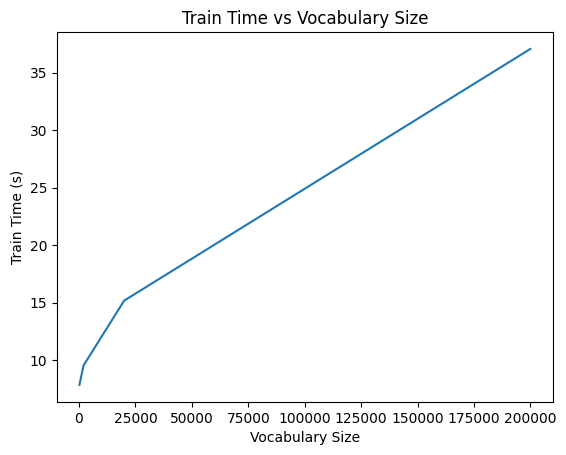

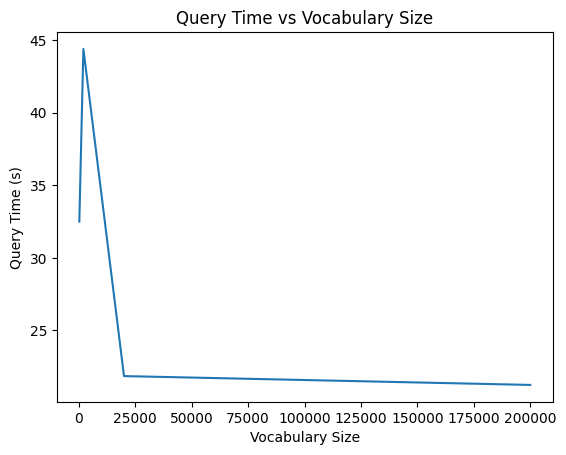

In [84]:
import matplotlib.pyplot as plt

# vocabulary sizes
vocab_sizes = [200, 2000, 20000, 200000]

# lists to store results
mAPs = []
train_times = []
query_times = []

# loop through vocabulary sizes
for size in vocab_sizes:
    # create BoW object
    index = BoW('../clust/clust_flickr60_k{}.fvecs'.format(size))
    
    # build database
    start_time = time.time()
    index.build_db(train_names, train_desc)
    train_time = time.time() - start_time
    
    # compute mAP
    start_time = time.time()
    results, mAP = index.compute_mAP(query_names, query_desc)
    query_time = time.time() - start_time
    
    # append results to lists
    mAPs.append(mAP)
    train_times.append(train_time)
    query_times.append(query_time)

# plot mAP vs vocabulary size
plt.plot(vocab_sizes, mAPs)
plt.title('mAP vs Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('mAP')
plt.show()

# plot train time vs vocabulary size
plt.plot(vocab_sizes, train_times)
plt.title('Train Time vs Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('Train Time (s)')
plt.show()

# plot query time vs vocabulary size
plt.plot(vocab_sizes, query_times)
plt.title('Query Time vs Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('Query Time (s)')
plt.show()


mAP and training time increases when vocabulary size increases. However, query time first increase from 200 to 2000 words but after that it decreases when vocabulary size increases. Times are not constant for each vocabulary.

**Q11**: Do the results obtained depend on the set of images used to generate the vocabulary? How can we improve the retrieval performance?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

The results obtained can depend on the set of images used to generate the vocabulary. If the vocabulary is generated from a set of images that is not representative of the images we want to retrieve, then the performance can be poor.

One way to improve the retrieval performance is to use a larger and more diverse set of images to generate the vocabulary. Another approach is to use a more sophisticated feature extraction technique that captures more information about the images. Additionally, one could use more advanced techniques such as deep learning to learn feature representations that are more discriminative and robust to variations in the images.

### TF-IDF
As a final task of this assignment, let's implement the TF-IDF scoring scheme. Modify the `BoW` class you wrote before to include the TF-IDF weighting scheme:

In [144]:
from sklearn.feature_extraction.text import TfidfTransformer

class BoW_TFIDF:
    """
    Class to implement the BoW model + Inverted File + TF-IDF Scoring scheme
    """
  
    def __init__(self, vocab_file):
        """
        Class constructor. It loads the vocabulary and initializes other stuff
        required for the CBIR system, such as the inverted file structure.
        """
        self.vocab = rd.load_visual_vocab(vocab_file)
        self.nwords = self.vocab.getTrainDescriptors()[0].shape[0]
        self.train_names = []
        self.inv_list = {word_id: {} for word_id in range(self.nwords)}        
        self.tfidf = {}

    def build_db(self, img_names, img_descs):
        """
        Build an index from a set of images. Essentially, for each image, you should
        search its descriptors in the index in order to find the closest visual words
        and fill the inverted file structure consequently. Additionally, TF and IDF terms
        should be computed here.
    
        - img_names: An ordered list with the names of the train images
        - img_descs: A list containing numpy arrays. Each numpy array i corresponds 
          to the descriptors found at image i
        """
        # YOUR CODE HERE
        for i, img_desc in enumerate(img_descs):
            visual_words = self.vocab.knnMatch(img_desc, k=1)
            bow_hist = np.zeros(self.nwords)

            for vw in visual_words:
                word_id = vw[0].trainIdx
                bow_hist[word_id] += 1

            desc_len = len(img_desc)
            if desc_len != 0:
                bow_hist /= desc_len

            img_name = img_names[i]
            self.tfidf[img_name] = bow_hist

            for word_id, word_count in enumerate(bow_hist):
                if word_count > 0:
                    img_dict = self.inv_list[word_id]
                    img_dict[img_name] = img_dict.get(img_name, 0) + 1


    def search_image(self, descs):
        """
        Search an image in the index. Use the TF-IDF here when scoring the images.
      
        - descs: A numpy array. It is the set descriptors extracted from the query image.
    
        RETURN:
        - An ordered list of similar images, e.g.: ['100101.jpg', '100202.jpg', ...]
        """
        # YOUR CODE HERE
        visual_words = self.vocab.knnMatch(descs, k=1)
        bow_hist = np.zeros(self.nwords)

        for vw in visual_words:
            word_id = vw[0].trainIdx
            bow_hist[word_id] += 1
            
        if len(descs) != 0:
            bow_hist /= len(descs)

        # Compute the TF-IDF score for each image in the index
        scores = {}
        for word_id, word_count in enumerate(bow_hist):
            if word_count == 0:
                continue
            for image_id, idf in self.inv_list[word_id].items():
                if image_id not in scores:
                    scores[image_id] = 0
                scores[image_id] += word_count * idf

        sorted_images = sorted(scores, key=scores.get, reverse=True)
        return sorted_images
        
    def compute_mAP(self, query_names, query_descs, gt_file='../holidays/holidays_images.dat'):
        """
        Perform a search for a list of query images against the database and evaluates
        the performance of the system.
        
        - query_names: An ordered list with the names of query images
        - query_descs: A list containing numpy arrays of size (ndesc_for_this_image, 128). 
              Each numpy array i corresponds to the descriptors found at image i.

        RETURN:
        - total_results: A dictionary containing, for each query image, an ordered list of the retrieved images.
        - m_ap: Mean Average Precision averaged over all queries.
        """
        total_results = {}
        m_ap = 0.0
        
        # YOUR CODE HERE
        for qname, qdesc in zip(query_names, query_descs):
            # Search for similar images
            results = self.search_image(qdesc)
            total_results[qname] = results

        m_ap = ev.compute_mAP(total_results, gt_file)
        
        return total_results, m_ap

In [145]:
# Example of use
index = BoW_TFIDF('../clust/clust_flickr60_k200.fvecs')
index.build_db(train_names[0:2], train_desc[0:2])

In [146]:
res = index.search_image(query_desc[0])
print(res)

['100001.jpg', '100002.jpg']


**Q12**: In the following cell compute the resulting mAP of the system **using the vocabularies of 200, 2K, 20K and 200K visual words**:

In [147]:
# Fill these variables with the resulting mAP
mAP_200  = 0.0
mAP_2K   = 0.0
mAP_20K  = 0.0
mAP_200K = 0.0

import time

# YOUR CODE HERE
def build_index_and_compute_map(clust_file, train_names, train_desc, query_names, query_desc):
    start_time = time.time()
    index = BoW_TFIDF(clust_file)
    index.build_db(train_names, train_desc)
    train_time = time.time() - start_time
    results, mAP = index.compute_mAP(query_names, query_desc)
    return results, mAP, train_time

clust_files = ['../clust/clust_flickr60_k200.fvecs', 
               '../clust/clust_flickr60_k2000.fvecs', 
               '../clust/clust_flickr60_k20000.fvecs', 
               '../clust/clust_flickr60_k200000.fvecs']

results_200, mAP_200, train_time_200 = build_index_and_compute_map(clust_files[0], train_names, train_desc, query_names, query_desc)
print("Training time for 200 words: ", train_time_200)

results_2K, mAP_2K, train_time_2K = build_index_and_compute_map(clust_files[1], train_names, train_desc, query_names, query_desc)
print("Training time for 2K words: ", train_time_2K)

results_20K, mAP_20K, train_time_20K = build_index_and_compute_map(clust_files[2], train_names, train_desc, query_names, query_desc)
print("Training time for 20K words: ", train_time_20K)

results_200K, mAP_200K, train_time_200K = build_index_and_compute_map(clust_files[3], train_names, train_desc, query_names, query_desc)
print("Training time for 200K words: ", train_time_200K)

Training time for 200 words:  7.585897207260132
Training time for 2K words:  7.91837477684021
Training time for 20K words:  14.129463911056519
Training time for 200K words:  37.93819189071655


In [148]:
print('mAP 200: %.5f' % mAP_200)
print('mAP 2K: %.5f' % mAP_2K)
print('mAP 20K: %.5f' % mAP_20K)
print('mAP 200K: %.5f' % mAP_200K)

mAP 200: 0.05085
mAP 2K: 0.41678
mAP 20K: 0.45866
mAP 200K: 0.51423


**Q13:** Compare the performances obtained on each case. Is a larger vocabulary size always better? Why or why not?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

Similar to the initial implementation, there is a positive correlation between the vocabulary size and performance, which comes at the cost of increased computational time. Larger vocabulary size does not always guarantee better performance. Increasing the size of the vocabulary leads to a higher level of granularity in the description of the visual content, which can be useful in distinguishing between similar images. However, too much granularity can also result in overfitting, where the system becomes too specialized to the training dataset and fails to generalize well to unseen data.

Additionally, a larger vocabulary size requires more computational resources, both for building the index and for performing the retrieval. Therefore, there is a trade-off between accuracy and efficiency, and the optimal vocabulary size depends on the specific application.



**Q14**: Analyze the effect of the vocabulary size in terms of mAP and average response time (train and query times). Are these times constant for each vocabulary? Some plots here can be useful to justify your answer.

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

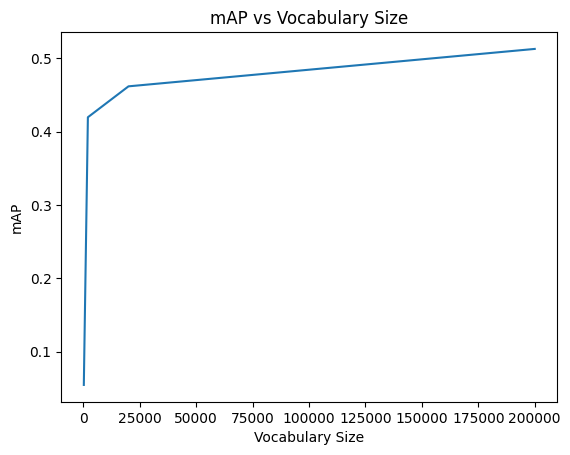

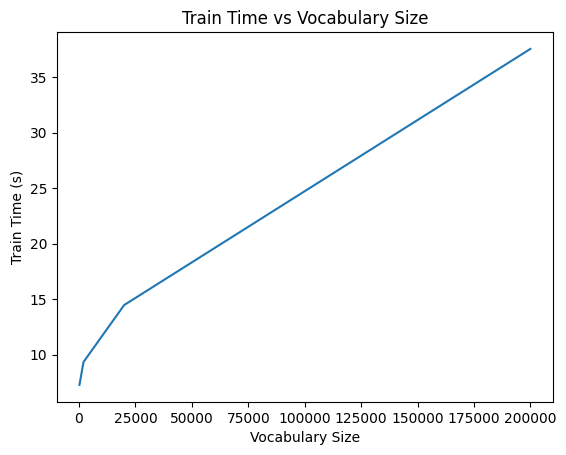

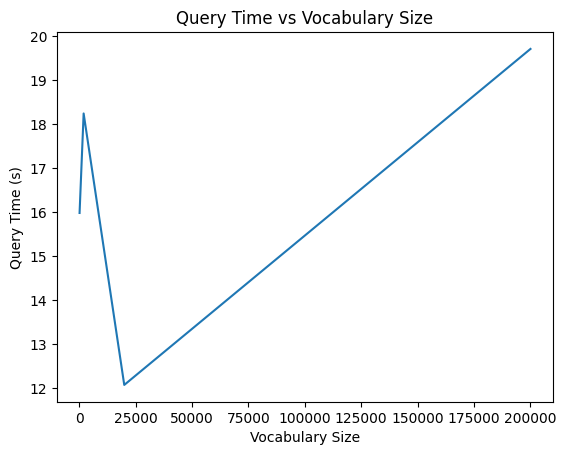

In [149]:
import matplotlib.pyplot as plt

# vocabulary sizes
vocab_sizes = [200, 2000, 20000, 200000]

# lists to store results
mAPs = []
train_times = []
query_times = []

# loop through vocabulary sizes
for size in vocab_sizes:
    # create BoW object
    index = BoW_TFIDF('../clust/clust_flickr60_k{}.fvecs'.format(size))
    
    # build database
    start_time = time.time()
    index.build_db(train_names, train_desc)
    train_time = time.time() - start_time
    
    # compute mAP
    start_time = time.time()
    results, mAP = index.compute_mAP(query_names, query_desc)
    query_time = time.time() - start_time
    
    # append results to lists
    mAPs.append(mAP)
    train_times.append(train_time)
    query_times.append(query_time)

# plot mAP vs vocabulary size
plt.plot(vocab_sizes, mAPs)
plt.title('mAP vs Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('mAP')
plt.show()

# plot train time vs vocabulary size
plt.plot(vocab_sizes, train_times)
plt.title('Train Time vs Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('Train Time (s)')
plt.show()

# plot query time vs vocabulary size
plt.plot(vocab_sizes, query_times)
plt.title('Query Time vs Vocabulary Size')
plt.xlabel('Vocabulary Size')
plt.ylabel('Query Time (s)')
plt.show()


mAP value and training time increases when the vocabulary size increases but query time has a different relation. The one with vocabulary size 20K has the lowest guerying time. So the times are not constant.

**Q15**: Do the results obtained depend on the set of images used to generate the vocabulary? How can we improve the retrieval performance?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

Yes, the results obtained can depend on the set of images used to generate the vocabulary. If the vocabulary is generated using a limited or biased set of images, it may not capture the visual characteristics of the images in the test set, leading to poor retrieval performance. To address this, it is important to generate the vocabulary using a diverse and representative set of images that captures the visual characteristics of the images in the test set.

To improve the retrieval performance, one approach is to use more advanced techniques such as deep learning-based feature extraction and indexing. Another approach is to use more sophisticated matching algorithms such as spatial verification, which takes into account the spatial relationships between the query image and the database images. Additionally, using a larger training set and applying data augmentation techniques can improve the robustness and generalization of the system. Finally, incorporating semantic information such as object detection and scene understanding can further improve the retrieval performance by incorporating high-level information into the matching process.

**Q16:** How does TF-IDF affect the performance? Better or worse? Does this make sense?

Write here the code required to answer the questions stated above. You can add more cells (code / markdown) at this point if you need it.

TF-IDF improves the performance of a Bag-of-Words model by assigning higher weights to the more discriminative visual words that appear frequently in some images but not in others. This helps to reduce the impact of common words that occur frequently in all images but are not informative for distinguishing between them.

In the case of the smallest vocabulary size of 200, the mAP decreased from 0.06577 to 0.05085 with the addition of TF-IDF. However, for the larger vocabulary sizes of 2K, 20K, and 200K, TF-IDF led to significant improvements in performance, with mAP values of 0.41678, 0.45866, and 0.51423 respectively, compared to mAP values of 0.13785, 0.25445, and 0.38384 obtained without TF-IDF.

Therefore, we can conclude that the effect of TF-IDF on the retrieval performance depends on the vocabulary size. For larger vocabulary sizes, TF-IDF seems to improve the retrieval performance, while for smaller vocabulary sizes, it can lead to a decrease in performance. This makes sense since TF-IDF aims to downweight common terms that are unlikely to be discriminative, and when the vocabulary size is small, some of the informative terms might be wrongly downweighted, leading to a decrease in performance.

---

&copy; Emilio Garcia-Fidalgo, University of the Balearic Islands